In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Importing the data

In [2]:
raw_data = pd.read_csv('Index2018.csv')
raw_data.head()
# market indexes

,date,spx,dax,ftse,nikkei
0,07/01/1994,469.90,2224.95,3445.98,18124.01
1,10/01/1994,475.27,2225.00,3440.58,18443.44
2,11/01/1994,474.13,2228.10,3413.77,18485.25
3,12/01/1994,474.17,2182.06,3372.02,18793.88
4,13/01/1994,472.47,2142.37,3360.01,18577.26


## Transform raw data into Time-Series Data

In [3]:
df = raw_data.copy()
df.date = pd.to_datetime(df.date, dayfirst = True)
df.set_index('date', inplace = True)
df = df.asfreq('b') # 'b' - business days
df.fillna(method = 'ffill', inplace = True)
df.head()

,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25
1994-01-12,474.17,2182.06,3372.02,18793.88
1994-01-13,472.47,2142.37,3360.01,18577.26


In [4]:
df.isna().sum()

spx       0
dax       0
ftse      0
nikkei    0
dtype: int64

## Using Returns

In [5]:
# create returns out of prices
# returns = (p(t) - p(t-1)) / p(t-1)
df['ftse_returns'] = df.ftse.pct_change(1).mul(100)
df.head()

,spx,dax,ftse,nikkei,ftse_returns
date,,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01,NaN
1994-01-10,475.27,2225.00,3440.58,18443.44,-0.156704
1994-01-11,474.13,2228.10,3413.77,18485.25,-0.779229
1994-01-12,474.17,2182.06,3372.02,18793.88,-1.222988
1994-01-13,472.47,2142.37,3360.01,18577.26,-0.356166


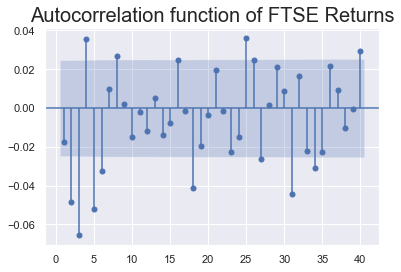

In [6]:
import statsmodels.graphics.tsaplots as sgt

sgt.plot_acf(df.ftse_returns.iloc[1:], lags = 40, zero = False)
plt.title('Autocorrelation function of FTSE Returns', size = 20)
plt.show()

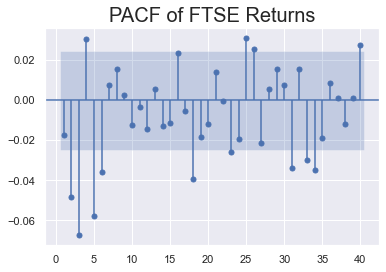

In [7]:
sgt.plot_pacf(df.ftse_returns.iloc[1:], lags = 40, zero = False, alpha = 0.05, method = ('ols'))
plt.title('PACF of FTSE Returns', size = 20)
plt.show()

## Log Likelihood Ratio (LLR) Test

In [8]:
from scipy.stats.distributions import chi2

def LLR_test(model_1, model_2, DF = 1):
    L1 = model_1.fit().llf
    L2 = model_2.fit().llf
    
    LR = 2*(L2 - L1)
    p = chi2.sf(LR, DF).round(3)
    
    return p

## ARIMA(1, 1, 1) model

In [9]:
from statsmodels.tsa.arima.model import ARIMA

# use price values, not returns!
arima_1_1_1 = ARIMA(df.ftse, order = (1, 1, 1), trend = 't')
results_arima_1_1_1 = arima_1_1_1.fit()
results_arima_1_1_1.summary()

C:\Users\0x17h\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\0x17h\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   ftse   No. Observations:                 6277
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -34417.640
Date:                Thu, 17 Nov 2022   AIC                          68843.279
Time:                        18:56:29   BIC                          68870.257
Sample:                    01-07-1994   HQIC                         68852.626
                         - 01-29-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.6748      0.651      1.037      0.300      -0.601       1.950
ar.L1          0.8345      0.040     20.742      0.000       0.756       0.913
ma.L1         -0.8692      0.036    -24.153      0.000      -0.940      -0.799
sigma2      3396.0828     36.414     93.262      0.000    3324.712    3467.454
===================================================================================
Ljung-Box (L1) (Q):                   2.81   Jarque-Bera (JB):              3738.34
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                            -0.32
Prob(H) (two-sided):                  0.23   Kurtosis:                         6.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Residuals of ARIMA(1, 1, 1)

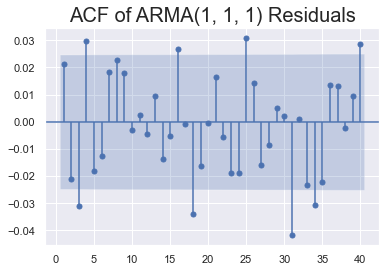

In [10]:
sgt.plot_acf(results_arima_1_1_1.resid.iloc[1:], lags = 40, zero = False)
plt.title('ACF of ARMA(1, 1, 1) Residuals', size = 20)
plt.show()

#the 3rd and 4th lag look significant 
# so oncorporating these lags into our model might significantly improve performance

## Higher-Lag ARIMA Models

In [11]:
arima_1_1_2 = ARIMA(df.ftse, order = (1, 1, 2), trend = 't')
results_arima_1_1_2 = arima_1_1_2.fit()

In [12]:
arima_1_1_3 = ARIMA(df.ftse, order = (1, 1, 3), trend = 't')
results_arima_1_1_3 = arima_1_1_3.fit()

In [13]:
arima_2_1_1 = ARIMA(df.ftse, order = (2, 1, 1), trend = 't')
results_arima_2_1_1 = arima_2_1_1.fit()

C:\Users\0x17h\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\0x17h\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [14]:
arima_3_1_1 = ARIMA(df.ftse, order = (3, 1, 1), trend = 't')
results_arima_3_1_1 = arima_3_1_1.fit()

In [15]:
arima_3_1_2 = ARIMA(df.ftse, order = (3, 1, 2), trend = 't')
results_arima_3_1_2 = arima_3_1_2.fit()

In [16]:
print('ARIMA(1, 1, 1) \tLL: {}, \tAIC: {}'.format(results_arima_1_1_1.llf, results_arima_1_1_1.aic))
print('ARIMA(1, 1, 2) \tLL: {}, \tAIC: {}'.format(results_arima_1_1_2.llf, results_arima_1_1_2.aic))
print('ARIMA(1, 1, 3) \tLL: {}, \tAIC: {}'.format(results_arima_1_1_3.llf, results_arima_1_1_3.aic))
print('ARIMA(2, 1, 1) \tLL: {}, \tAIC: {}'.format(results_arima_2_1_1.llf, results_arima_2_1_1.aic))
print('ARIMA(3, 1, 1) \tLL: {}, \tAIC: {}'.format(results_arima_3_1_1.llf, results_arima_3_1_1.aic))
print('ARIMA(3, 1, 2) \tLL: {}, \tAIC: {}'.format(results_arima_3_1_2.llf, results_arima_3_1_2.aic))

# best model is ARIMA(1, 1, 3)

ARIMA(1, 1, 1) 	LL: -34417.63955442267, 	AIC: 68843.27910884534
ARIMA(1, 1, 2) 	LL: -34413.656065305666, 	AIC: 68837.31213061133
ARIMA(1, 1, 3) 	LL: -34410.77123091695, 	AIC: 68833.5424618339
ARIMA(2, 1, 1) 	LL: -34413.513513094294, 	AIC: 68837.02702618859
ARIMA(3, 1, 1) 	LL: -34412.27306117971, 	AIC: 68836.54612235942
ARIMA(3, 1, 2) 	LL: -34410.80565044164, 	AIC: 68835.61130088328


In [17]:
# but ARIMA(1, 1, 1) and ARIMA(1, 1, 2) models are both nested for the ARIMA(1, 1, 3)
# we need to run LLR test to make sure it significantly outperforms them
LLR_test(arima_1_1_1, arima_1_1_3, DF = 2)

0.001

In [18]:
LLR_test(arima_1_1_2, arima_1_1_3, DF = 1)

0.016

So as a result we can conclude that ARIMA(1, 1, 3) is the best choice

## Explore Residuals of ARIMA(1, 1, 3)

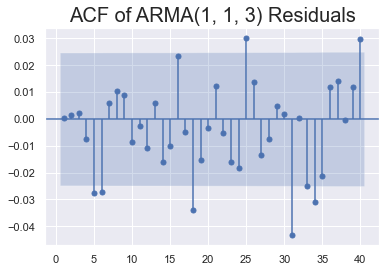

In [19]:
sgt.plot_acf(results_arima_1_1_3.resid.iloc[1:], lags = 40, zero = False)
plt.title('ACF of ARMA(1, 1, 3) Residuals', size = 20)
plt.show()

# it might be a better model that includes 5 and 6 lags!

In [20]:
arima_5_1_1 = ARIMA(df.ftse, order = (5, 1, 1), trend = 't')
results_arima_5_1_1 = arima_5_1_1.fit()

In [21]:
arima_6_1_3 = ARIMA(df.ftse, order = (6, 1, 3), trend = 't')
results_arima_6_1_3 = arima_6_1_3.fit()

In [22]:
print('ARIMA(1, 1, 3) \tLL: {}, \tAIC: {}'.format(results_arima_1_1_3.llf, results_arima_1_1_3.aic))
print('ARIMA(5, 1, 1) \tLL: {}, \tAIC: {}'.format(results_arima_5_1_1.llf, results_arima_5_1_1.aic))
print('ARIMA(6, 1, 3) \tLL: {}, \tAIC: {}'.format(results_arima_6_1_3.llf, results_arima_6_1_3.aic))

ARIMA(1, 1, 3) 	LL: -34410.77123091695, 	AIC: 68833.5424618339
ARIMA(5, 1, 1) 	LL: -34406.527814174595, 	AIC: 68829.05562834919
ARIMA(6, 1, 3) 	LL: -34405.1247539128, 	AIC: 68832.2495078256


In [23]:
# ARIMA(5, 1, 1) vs ARIMA(6, 1, 3)
LLR_test(arima_5_1_1, arima_6_1_3, DF = 3)

0.422

In [24]:
# ARIMA(1, 1, 3) vs ARIMA(6, 1, 3)
LLR_test(arima_1_1_3, arima_6_1_3, DF = 5)

0.046

**ARIMA(5, 1, 1)** > ARIMA(6, 1, 3) > ARIMA(1, 1, 3)<br/>
ARIMA(5, 1, 1) is the best model

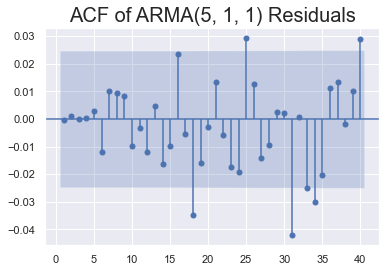

In [25]:
sgt.plot_acf(results_arima_5_1_1.resid.iloc[1:], lags = 40, zero = False)
plt.title('ACF of ARMA(5, 1, 1) Residuals', size = 20)
plt.show()

In [26]:
results_arima_5_1_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   ftse   No. Observations:                 6277
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -34406.528
Date:                Thu, 17 Nov 2022   AIC                          68829.056
Time:                        18:59:36   BIC                          68883.012
Sample:                    01-07-1994   HQIC                         68847.750
                         - 01-29-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.6735      0.667      1.009      0.313      -0.634       1.981
ar.L1          0.3697      0.160      2.316      0.021       0.057       0.683
ar.L2         -0.0457      0.009     -4.876      0.000      -0.064      -0.027
ar.L3         -0.0382      0.012     -3.223      0.001      -0.061      -0.015
ar.L4          0.0293      0.013      2.322      0.020       0.005       0.054
ar.L5         -0.0454      0.008     -5.435      0.000      -0.062      -0.029
ma.L1         -0.3820      0.160     -2.386      0.017      -0.696      -0.068
sigma2      3386.5365     37.145     91.171      0.000    3313.734    3459.339
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3484.19
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                            -0.30
Prob(H) (two-sided):                  0.13   Kurtosis:                         6.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Models with higher levels of Integration

In [27]:
df['delta_ftse'] = df.ftse.diff(1)

In [28]:
# trying to fit ARMA(1, 1) for delta values
# we expect to get the same results as for ARIMA(1, 1, 1) model
arma_1_1 = ARIMA(df.delta_ftse[1:], order = (1, 0, 1), trend = 'c')
results_arma_1_1 = arma_1_1.fit()
results_arma_1_1.summary()

C:\Users\0x17h\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\0x17h\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             delta_ftse   No. Observations:                 6276
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -34417.643
Date:                Thu, 17 Nov 2022   AIC                          68843.285
Time:                        18:59:43   BIC                          68870.263
Sample:                    01-10-1994   HQIC                         68852.633
                         - 01-29-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6746      0.650      1.037      0.300      -0.600       1.949
ar.L1          0.8356      0.040     20.896      0.000       0.757       0.914
ma.L1         -0.8702      0.036    -24.338      0.000      -0.940      -0.800
sigma2      3395.4411     36.399     93.284      0.000    3324.100    3466.782
===================================================================================
Ljung-Box (L1) (Q):                   2.78   Jarque-Bera (JB):              3739.27
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                            -0.32
Prob(H) (two-sided):                  0.23   Kurtosis:                         6.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
import statsmodels.tsa.stattools as sts

sts.adfuller(df.delta_ftse[1:])

(-35.62356825180309,
 0.0,
 5,
 6270,
 {'1%': -3.4313933778649943,
  '5%': -2.862001080749219,
  '10%': -2.567015430304048},
 68467.67159603654)